## Import Libraries

In [812]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_score
from sklearn import metrics
from sklearn.mixture import GaussianMixture

## Load and Explore Dataset

In [813]:
data = pd.read_csv('dataset.csv')

In [814]:
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [815]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [816]:
print(data.isnull().sum())

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


In [817]:
print(data.describe())

               age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1.000000   9382.033000
75%      51.000000    34.693750     2.000000  16639.912515
max      64.000000    53.130000     5.000000  63770.428010


In [818]:
print(data.describe(include=['O']))

         sex smoker     region
count   1338   1338       1338
unique     2      2          4
top     male     no  southeast
freq     676   1064        364


## Data Cleaning

In [819]:
# use one hot encoding for 'sex','smoker','region'
cleaned_data = pd.get_dummies(data, columns=['sex','smoker','region'], prefix=['sex','smoker','region'])

# convert all bool columns to integers
for col in cleaned_data.columns:
    if cleaned_data[col].dtype == 'bool':
        cleaned_data[col] = cleaned_data[col].astype(int)

cleaned_data.head()

,age,bmi,children,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,1,0,0,1,0,0,0,1
1,18,33.770,1,1725.55230,0,1,1,0,0,0,1,0
2,28,33.000,3,4449.46200,0,1,1,0,0,0,1,0
3,33,22.705,0,21984.47061,0,1,1,0,0,1,0,0
4,32,28.880,0,3866.85520,0,1,1,0,0,1,0,0


In [820]:
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               1338 non-null   int64  
 1   bmi               1338 non-null   float64
 2   children          1338 non-null   int64  
 3   charges           1338 non-null   float64
 4   sex_female        1338 non-null   int32  
 5   sex_male          1338 non-null   int32  
 6   smoker_no         1338 non-null   int32  
 7   smoker_yes        1338 non-null   int32  
 8   region_northeast  1338 non-null   int32  
 9   region_northwest  1338 non-null   int32  
 10  region_southeast  1338 non-null   int32  
 11  region_southwest  1338 non-null   int32  
dtypes: float64(2), int32(8), int64(2)
memory usage: 83.8 KB


## Exploratory Data Analysis (EDA)

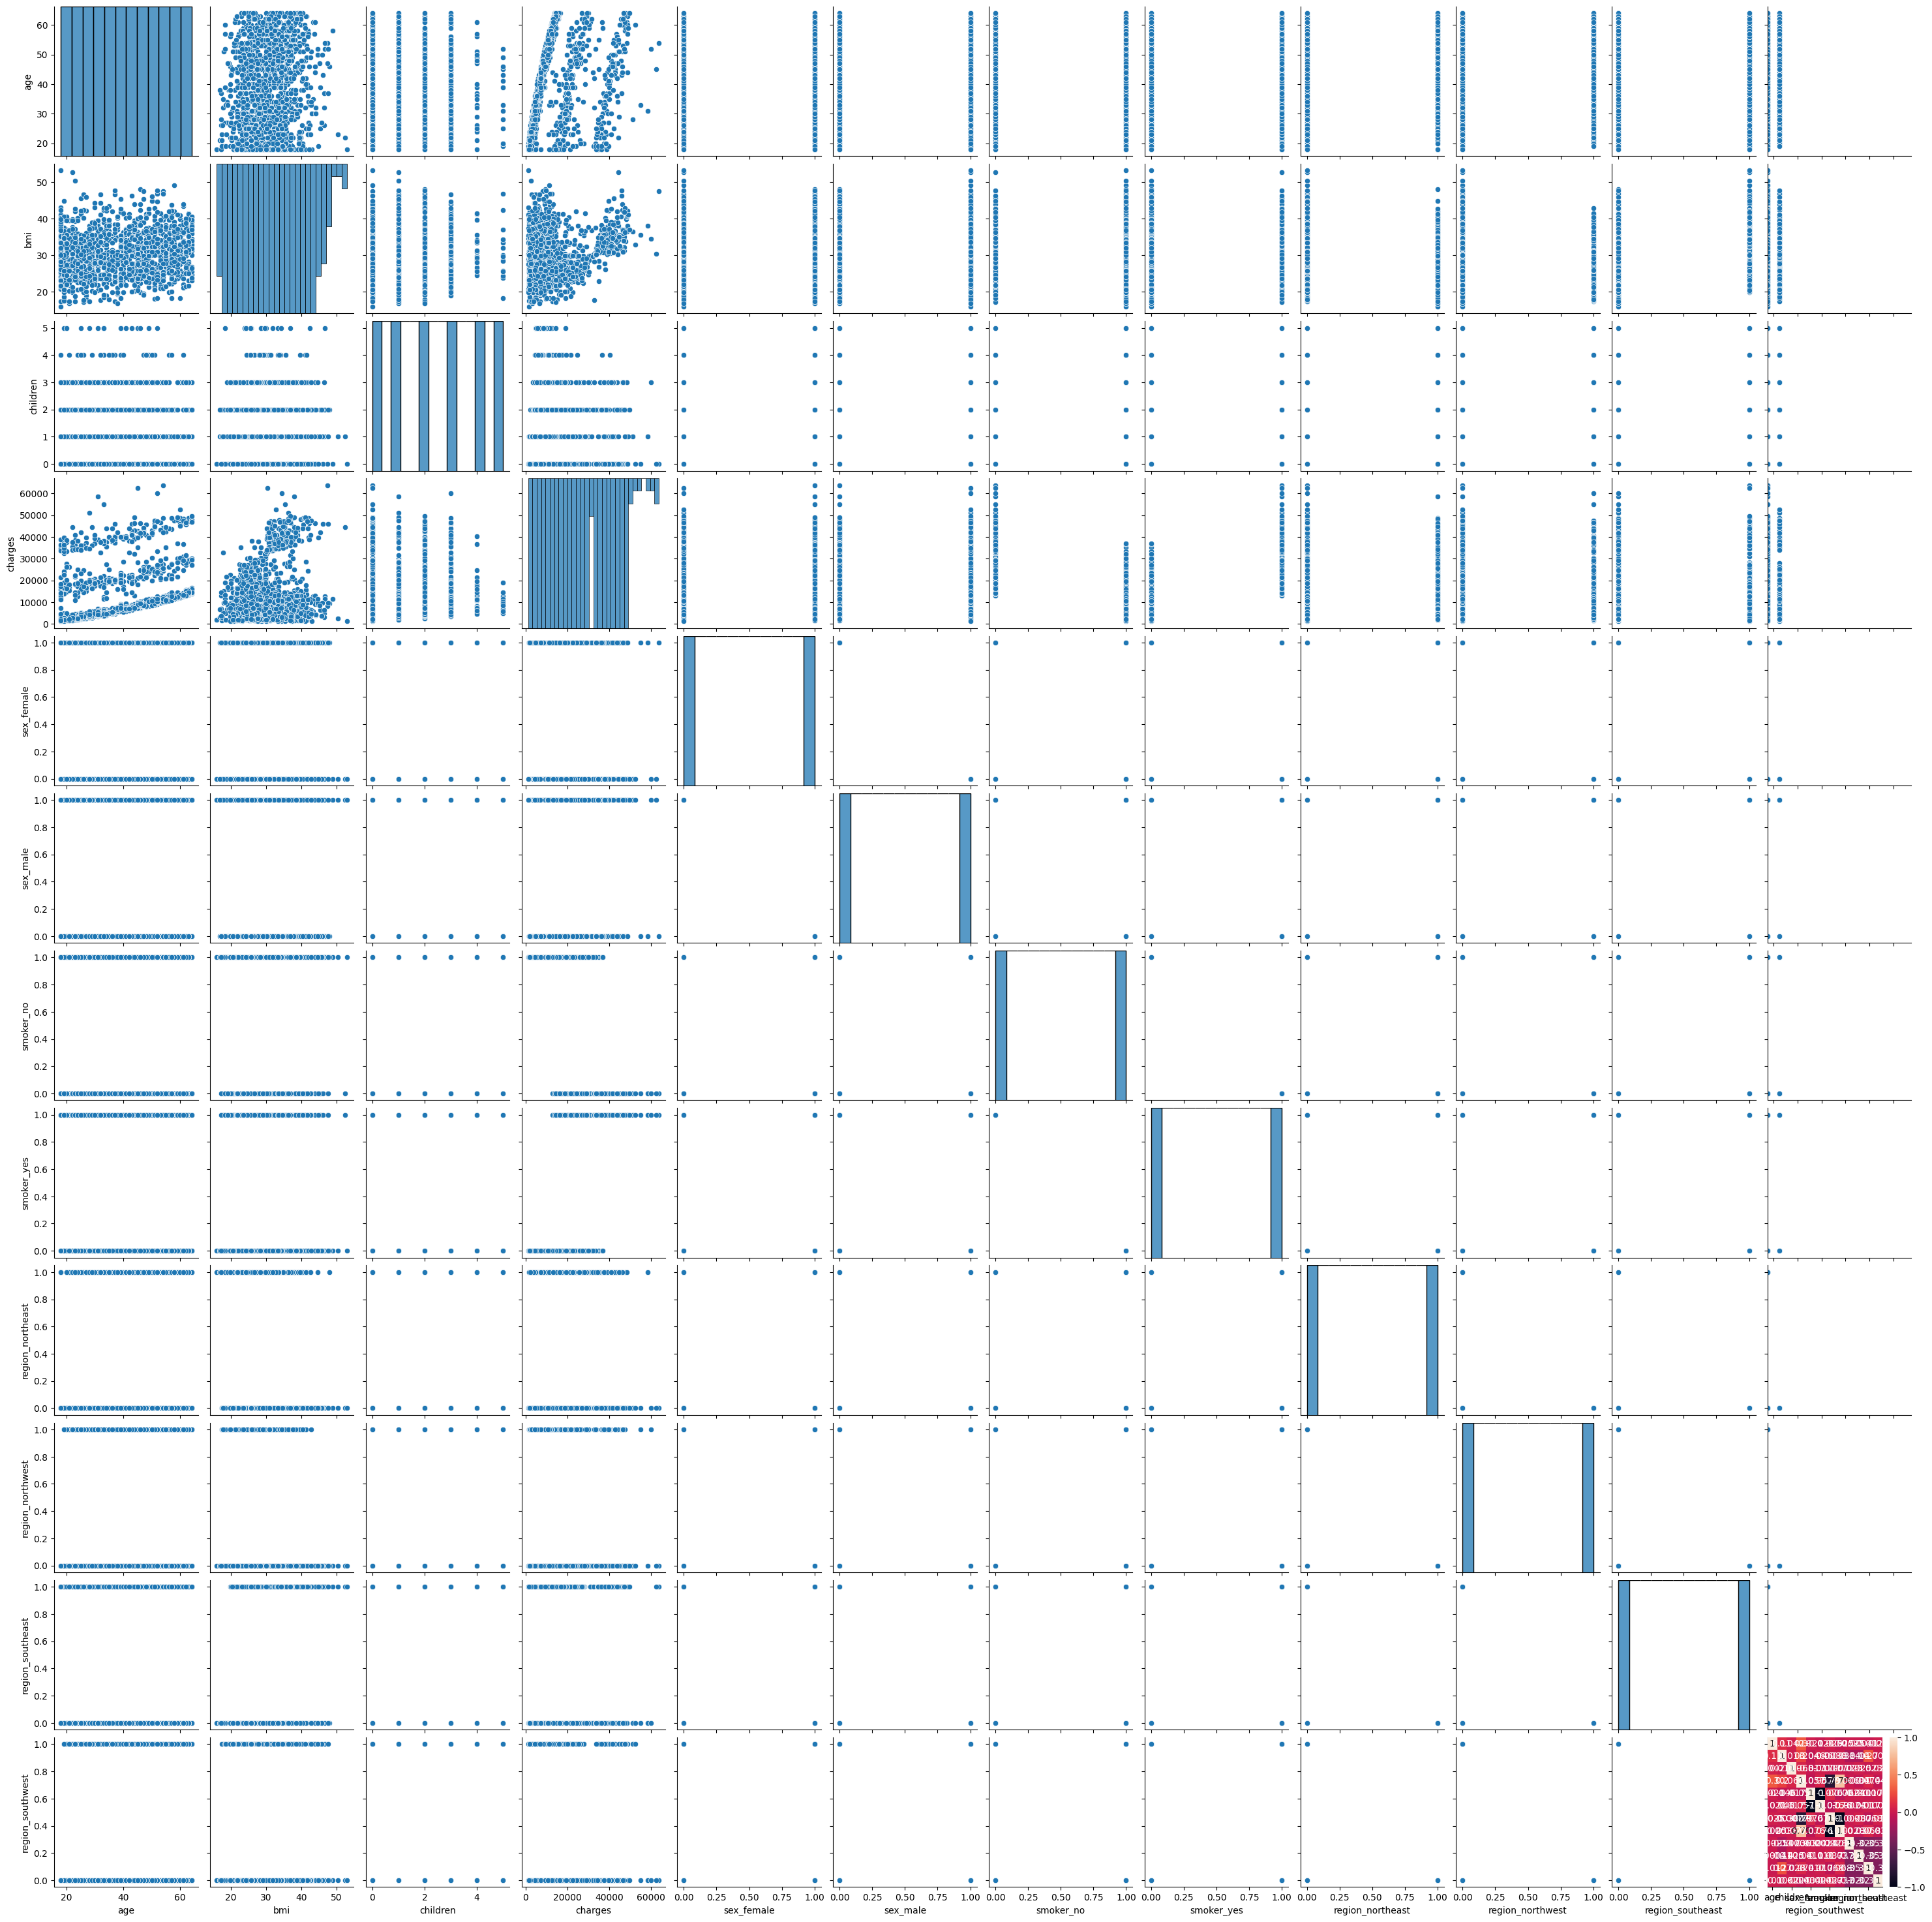

In [821]:
sns.pairplot(cleaned_data)
sns.heatmap(cleaned_data.corr(), annot=True)
plt.show()

## Data Preprocessing

In [822]:
# Data Scaling
scaler = StandardScaler()
scaled_data = scaler.fit_transform(cleaned_data)

## Dimensionality Reduction

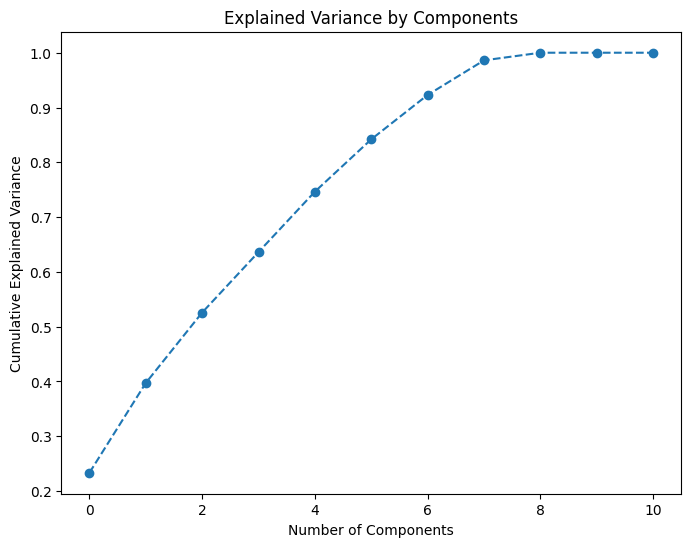

In [823]:
# PCA to reduce dimensionality for easier clustering
pca = PCA(n_components=11)
pca_features = pca.fit_transform(scaled_data)

# Plot cumulative variance to decide the number of components
plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Components')
plt.show()

pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_data)

## Unsupervised Learning (Clustering)

### K-Means Custering

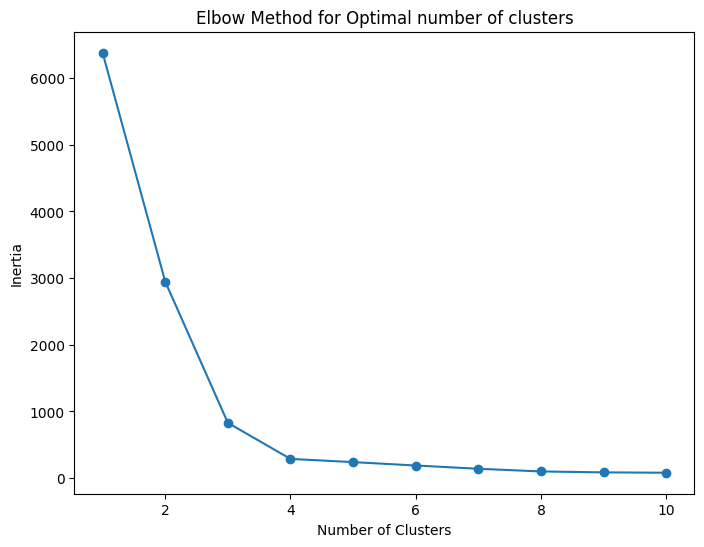

In [824]:
# Determine optimal clusters using the Elbow Method
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=122)
    kmeans.fit(pca_features)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal number of clusters')
plt.show()

In [825]:
# Apply clustering
kmeans = KMeans(n_clusters=4, random_state=122)
kmeans_clusters = kmeans.fit_predict(pca_features)

In [826]:
# Evaluate clustering performance
silhouette_avg_kmeans = silhouette_score(pca_features, kmeans_clusters)
davies_bouldin_kmeans = metrics.davies_bouldin_score(pca_features, kmeans_clusters)
# adjusted_rand_index_kmeans = metrics.adjusted_rand_score(pca_features.flatten(), kmeans_clusters.flatten())

print("Silhouette Score (K Means):", silhouette_avg_kmeans)
print("Davies-Bouldin Index (K Means):", davies_bouldin_kmeans)

Silhouette Score (K Means): 0.8182369293391899
Davies-Bouldin Index (K Means): 0.32197907447592183


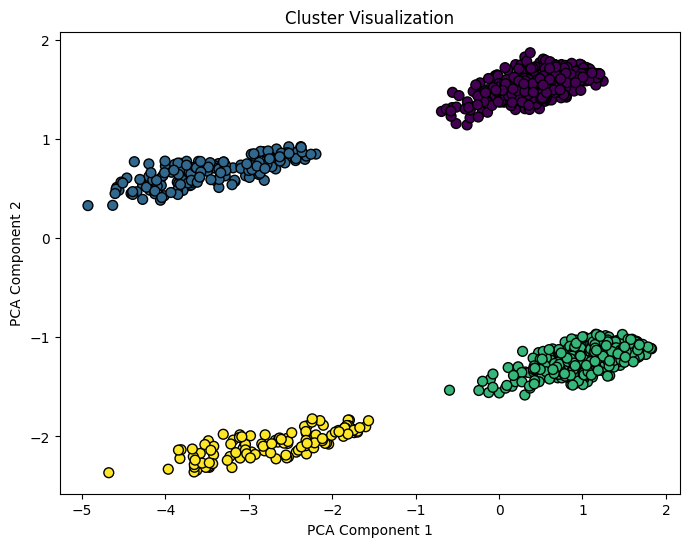

In [827]:
# Visualize clusters in PCA-reduced space
plt.figure(figsize=(8, 6))
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=kmeans_clusters, cmap='viridis', marker='o', edgecolor='k', s=50)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Cluster Visualization')
plt.show()

### DBSCAN Clustering

In [828]:
dbscan = DBSCAN(eps=40, min_samples=20)
dbscan_clusters = dbscan.fit_predict(cleaned_data)
cleaned_data['DBSCAN Cluster'] = dbscan_clusters

In [829]:
pca = PCA(n_components=3)
pca_features = pca.fit_transform(scaled_data)

In [830]:
# Evaluate clustering performance
silhouette_avg_dbscan = silhouette_score(pca_features, dbscan_clusters)
davies_bouldin_dbscan = metrics.davies_bouldin_score(pca_features, dbscan_clusters)

print("Silhouette Score (DBSCAN):", silhouette_avg_dbscan)
print("Davies-Bouldin Index (DBSCAN):", davies_bouldin_dbscan)

Silhouette Score (DBSCAN): -0.04791331778534256
Davies-Bouldin Index (DBSCAN): 3.222682184588474


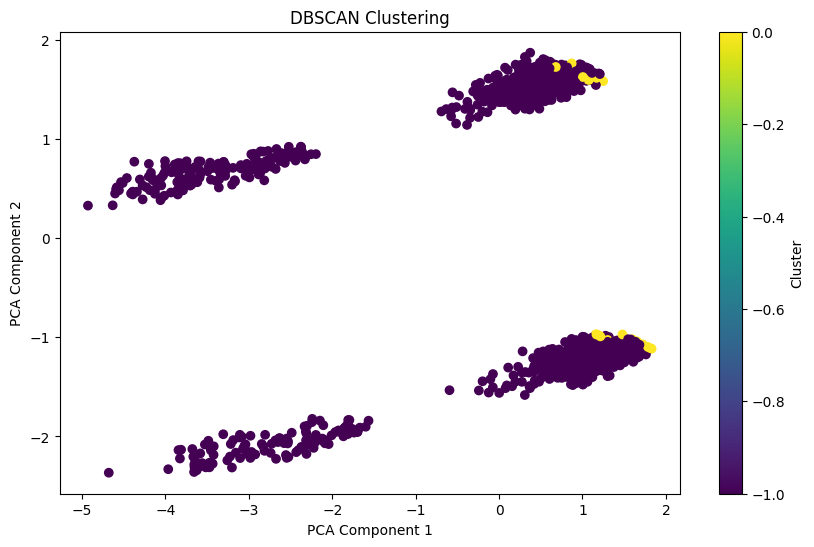

In [831]:
plt.figure(figsize=(10, 6))
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=dbscan_clusters, cmap='viridis')
plt.title('DBSCAN Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

### Gaussian Mixture

In [904]:
gmm = GaussianMixture(n_components=2, random_state=122)  # Specify number of clusters
gmm_clusters = gmm.fit_predict(scaled_data)

# Add cluster labels to the original dataset
cleaned_data['GMM_Cluster'] = gmm_clusters

In [905]:
silhouette_avg = silhouette_score(scaled_data, gmm_clusters)
print(f"Silhouette Score: {silhouette_avg}")

# Davies-Bouldin Index
dbi = metrics.davies_bouldin_score(scaled_data, gmm_clusters)
print(f"Davies-Bouldin Index: {dbi}")

Silhouette Score: 0.2854138374320771
Davies-Bouldin Index: 1.5206103734318863


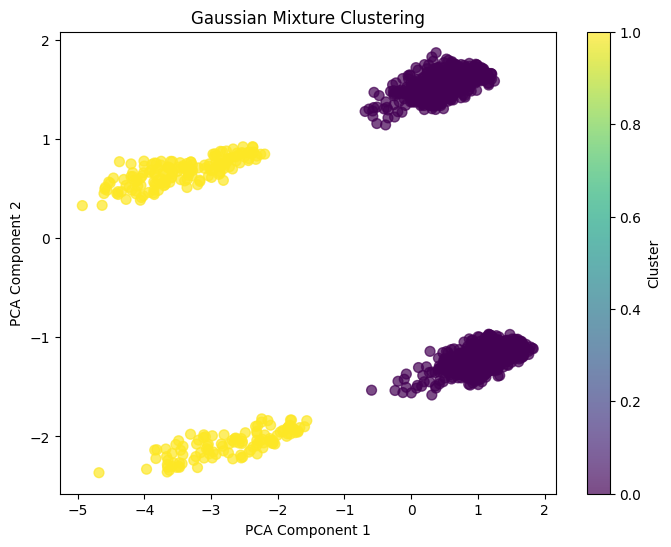

In [906]:
plt.figure(figsize=(8, 6))
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=gmm_clusters, cmap='viridis', s=50, alpha=0.7)
plt.title("Gaussian Mixture Clustering")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label='Cluster')
plt.show()

## Insights and Interpretation

### K Means

In [907]:
cleaned_data['K Means Cluster'] = kmeans_clusters
cluster_summary = cleaned_data.groupby('K Means Cluster').mean()
print(cluster_summary)

                       age        bmi  children       charges  sex_female  \
K Means Cluster                                                             
0                39.061896  30.770580  1.092843   8087.204731         0.0   
1                38.446541  31.504182  1.188679  33042.005975         0.0   
2                39.691042  30.539525  1.087751   8762.297300         1.0   
3                38.608696  29.608261  1.008696  30678.996276         1.0   

                 sex_male  smoker_no  smoker_yes  region_northeast  \
K Means Cluster                                                      
0                     1.0        1.0         0.0          0.241779   
1                     1.0        0.0         1.0          0.238994   
2                     0.0        1.0         0.0          0.241316   
3                     0.0        0.0         1.0          0.252174   

                 region_northwest  region_southeast  region_southwest  \
K Means Cluster                            

### DBSCAN

In [908]:
# Cluster Summary
cluster_summary = cleaned_data.groupby('DBSCAN Cluster').mean()
print(cluster_summary)

                      age        bmi  children       charges  sex_female  \
DBSCAN Cluster                                                             
-1              39.920340  30.738488  1.129157  13673.840548    0.498067   
 0              18.711111  28.505778  0.111111   1678.870276    0.400000   

                sex_male  smoker_no  smoker_yes  region_northeast  \
DBSCAN Cluster                                                      
-1              0.501933    0.78809     0.21191          0.244393   
 0              0.600000    1.00000     0.00000          0.177778   

                region_northwest  region_southeast  region_southwest  \
DBSCAN Cluster                                                         
-1                      0.242846          0.268368          0.244393   
 0                      0.244444          0.377778          0.200000   

                GMM_Cluster  K Means Cluster  
DBSCAN Cluster                                
-1                  0.21191        

### Gaussian Mixture

In [909]:
cleaned_data['GMM_Cluster'] = kmeans_clusters
cluster_summary = cleaned_data.groupby('GMM_Cluster').mean()
print(cluster_summary)

                   age        bmi  children       charges  sex_female  \
GMM_Cluster                                                             
0            39.061896  30.770580  1.092843   8087.204731         0.0   
1            38.446541  31.504182  1.188679  33042.005975         0.0   
2            39.691042  30.539525  1.087751   8762.297300         1.0   
3            38.608696  29.608261  1.008696  30678.996276         1.0   

             sex_male  smoker_no  smoker_yes  region_northeast  \
GMM_Cluster                                                      
0                 1.0        1.0         0.0          0.241779   
1                 1.0        0.0         1.0          0.238994   
2                 0.0        1.0         0.0          0.241316   
3                 0.0        0.0         1.0          0.252174   

             region_northwest  region_southeast  region_southwest  \
GMM_Cluster                                                         
0                    0.255